## Introduction

Here we are interested in the rish measurement of Portfolios which are assumed to follow a single-factor homogeneous model. The tail probabilities P(L > x) for loss thresholds x, is the risk measurement. 

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy.ndimage import gaussian_filter
from scipy.stats import gaussian_kde

from matplotlib.colors import LinearSegmentedColormap

In [19]:
th = 2.33
rho = 0.517 # Not given in the papers
N_samples = 1000000
n = 100 # num of obligators

eps = np.random.normal(0, 1, (N_samples, n))
Z = np.random.normal(0, 1, N_samples)

In [20]:
ci = 1 # the loss given Default
tail_th = 5 # x( the tail threshold)

In [21]:
# nominal - case  Risk Measurement (probability)
X_i = rho * Z[:, np.newaxis] + np.sqrt(1 - rho**2) * eps

def V(xi): # Xi comes from Z and eps
    defaults = xi > th
    loss = np.sum(defaults * ci)
    return loss > tail_th

L_greater_tail_th = np.apply_along_axis(V, 1, X_i)
print("P(L > x) = ", np.mean(L_greater_tail_th))

# We can backtrack from here to set the original rho in the second block,
#So that the mean of the L_greater_tail_th is 0.038

P(L > x) =  0.038366


In [22]:
#worst - case Risk Measurement (probability)
theta = 1

def Monte_carlo_worst_case(L_ID, theta):
     return np.sum(L_ID * np.exp(theta* L_ID))/ np.sum(np.exp(theta* L_ID))

def Rel_entropy(L_ID, theta):
    m_theta_i = np.exp(theta* L_ID)/ np.mean(np.exp(theta* L_ID))
    return np.mean(m_theta_i * np.log(m_theta_i))

# Function to calculate weighted mean and covariance
def weighted_mean_cov(X, weights):
    mean = np.average(X, axis=0, weights=weights)
    # this line is the montecarlo equivalent of E(m*(X - E(mX))^2)   Var = E((X - EX)^2)
    cov = np.cov(X.T, aweights=weights)
    return mean, cov

In [23]:
Prob_loss = Monte_carlo_worst_case(L_greater_tail_th, theta)
rel_entropy = Rel_entropy(L_greater_tail_th, theta)

print("Worst Case probablity measure: P(L > x) = ", Prob_loss)


Worst Case probablity measure: P(L > x) =  0.09783965808521003


In [24]:
# Estimate new parameters under worst-case measure
weights = np.exp(theta * L_greater_tail_th) # these don't sum to 1 but are handled in the weighted_mean_cov function
mean_Z, cov_Z = weighted_mean_cov(Z, weights)
mean_eps, cov_eps = weighted_mean_cov(eps, weights)

# Simulate with new parameters
new_Z = np.random.normal(mean_Z, cov_Z, N_samples)
new_eps = np.random.multivariate_normal(mean_eps, cov_eps, N_samples)

In [25]:
# New X_i with modified parameters
new_X_i = rho * new_Z[:, np.newaxis] + np.sqrt(1 - rho**2) * new_eps

# Apply V to new_X_i
new_L_greater_tail_th = np.apply_along_axis(V, 1, new_X_i)

print("P_tilda(L > x) = ", np.mean(new_L_greater_tail_th))                                        

P_tilda(L > x) =  0.081328


Note : the above probability is one calculated with modified parameters following the 'single-factor homogeneous model'.

Hence we can see that it has less probability that the worst case scenario.

### Risk Measurement Profile Vs Entropy

The below section repeats the experiment for a range of $\theta$ values and builds worst-case RP profiles. Simultaneously it also build the profile with that obtained from model parameter changes only.

At each relative entropy level, we simulate results under the worst-case change of measure (41); we estimate all model parameters (the means, standard deviations and correlations for the normal random variables Z, {$\epsilon$}_1, . . . , {$\epsilon$}_n); we then simulate the Gaussian copula model with these modified parameters.

In [26]:
results = {}
thetas = (np.exp(np.linspace(0, 1)) - 1)[1:]
for theta in thetas:
    Prob_loss = Monte_carlo_worst_case(L_greater_tail_th, theta)
    rel_entropy = Rel_entropy(L_greater_tail_th, theta)

    weights = np.exp(theta * L_greater_tail_th)
    mean_Z, cov_Z = weighted_mean_cov(Z, weights)
    mean_eps, cov_eps = weighted_mean_cov(eps, weights)

    # Simulate with new parameters
    new_Z = np.random.normal(mean_Z, cov_Z, N_samples)
    new_eps = np.random.multivariate_normal(mean_eps, cov_eps, N_samples)
    # New X_i with modified parameters
    new_X_i = rho * new_Z[:, np.newaxis] + np.sqrt(1 - rho**2) * new_eps
    
    new_L_greater_tail_th = np.apply_along_axis(V, 1, new_X_i)
    Param_wcProb_loss = np.mean(new_L_greater_tail_th)       
    
    results[theta] = [rel_entropy, Prob_loss, Param_wcProb_loss]

In [27]:
# Convert the dictionary to a list of tuples
data_list = [(key, *value) for key, value in results.items()]

# Create a DataFrame
df_wc = pd.DataFrame(data_list, columns=['theta', 'Rel_entropy', 'Prob_loss', 'Param_wcProb_loss'])

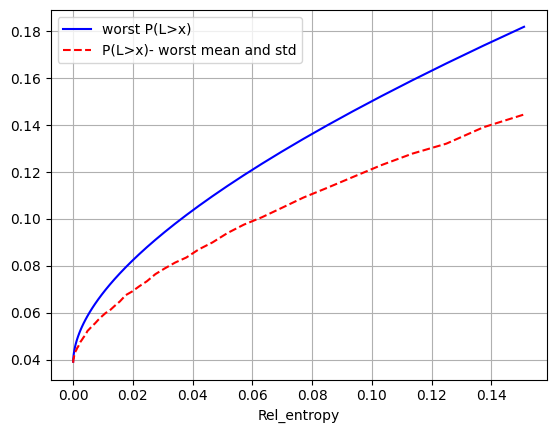

In [28]:
fig = plt.figure()
#fig.patch.set_facecolor('lightskyblue')
ax = plt.gca()
df_wc.plot(ax=ax, x='Rel_entropy',y='Prob_loss', linestyle='solid', linewidth=1.5, color='blue')
df_wc.plot(ax=ax, x='Rel_entropy', y='Param_wcProb_loss', linestyle='--', linewidth=1.5, color='red')
ax.legend(["worst P(L>x)", "P(L>x)- worst mean and std"])
ax.grid()
plt.show()

### Analysis of distributions of the stochastic variables

In [29]:
#analysis of theta in different cases; change value of theta here
theta = 2

all_stochs = np.concatenate((eps, Z[:, np.newaxis]), axis=1)
weights = np.exp(theta * L_greater_tail_th)
mean_s, cov_s = weighted_mean_cov(all_stochs, weights)

stddev = np.sqrt(np.diag(cov_s))
corr = cov_s / np.outer(stddev, stddev)

In [30]:
# Mask the diagonal elements
non_diagonal_mask = ~np.eye(corr.shape[0], dtype=bool)

# Extract the non-diagonal elements
non_diagonal_elements = corr[non_diagonal_mask]

max_rho = np.max(non_diagonal_elements)
min_rho = np.min(non_diagonal_elements)
avg_rho = np.mean(np.abs(non_diagonal_elements))
avg_mu = np.mean(mean_s[:-1])
avg_sigeps = np.mean(stddev[:-1])

skewness = np.zeros(n)
for i in range(n):
    m3 = np.sum(weights * (eps[:, i] - mean_s[i]) ** 3) / np.sum(weights)
    skewness[i] = m3 /(stddev[i] ** 3)

avg_skew = np.mean(skewness)

kurtosis = np.zeros(n)
for i in range(n):
    m4 = np.sum(weights * (eps[:, i] - mean_s[i]) ** 4) / (np.sum(weights)-1)
    m2 = np.sum(weights * (eps[:, i] - mean_s[i]) ** 2) / np.sum(weights)
    kurtosis[i] = (m4/ m2**2)  - 3

avg_ex_kurt = np.mean(kurtosis)

mean_Z = mean_s[-1]
stddev_Z = stddev[-1]

In [31]:
# Greek symbols
rho = '\u03C1'
mu = '\u03BC'
sigma = '\u03C3'
epsilon = '\u03B5'
# Print the values using formatted strings
print((f"max({rho}_ij, {rho}_iZ) :\t {max_rho:.3e} ").expandtabs(28))
print((f"min({rho}_ij, {rho}_iZ) :\t {min_rho:.3e} ").expandtabs(28))
print((f"average(|{rho}_ij|, |{rho}_iZ|) :\t {avg_rho:.3e} ").expandtabs(28))
print((f"average({mu}_j):\t {avg_mu:.3e} ").expandtabs(28))
print((f"average({sigma}_j):\t {avg_sigeps:.2f}").expandtabs(28))
print((f"average(skew_j):\t {avg_skew:.3e} ").expandtabs(28))
print((f"average(excess kurtosis_j):\t {avg_ex_kurt:.3e} ").expandtabs(28))
print((f"mean of Z:\t {mean_Z:.3f} ").expandtabs(28))
print((f"standard deviation of Z:\t {stddev_Z:.2f} ").expandtabs(28))

max(ρ_ij, ρ_iZ) :            1.236e-02 
min(ρ_ij, ρ_iZ) :            -4.815e-03 
average(|ρ_ij|, |ρ_iZ|) :    1.252e-03 
average(μ_j):                6.710e-03 
average(σ_j):                1.01
average(skew_j):             1.263e-02 
average(excess kurtosis_j):  -9.064e-05 
mean of Z:                   0.403 
standard deviation of Z:     1.23 


In [32]:
# Only Ex kurtosis is giving wrong values , mayb the formula is wrong.

### Contour plots of Joint Distribution

In [33]:
# Define the custom colormap
cdict = {
    'red':   [(0.0, 0.0, 0.0), (0.25, 0.0, 0.0), (0.5, 0.0, 0.0), (0.75, 1.0, 1.0), (1.0, 1.0, 1.0)],
    'green': [(0.0, 0.0, 0.0), (0.25, 0.0, 0.0), (0.5, 1.0, 1.0), (0.75, 1.0, 1.0), (1.0, 0.0, 0.0)],
    'blue':  [(0.0, 1.0, 1.0), (0.25, 1.0, 1.0), (0.5, 0.0, 0.0), (0.75, 0.0, 0.0), (1.0, 0.0, 0.0)]
}
custom_cmap = LinearSegmentedColormap('CustomMap', cdict)

Text(0.5, 1.0, 'Joint density of $\\epsilon_{99}$ and $\\epsilon_{100}$ with $\\theta = 2$')

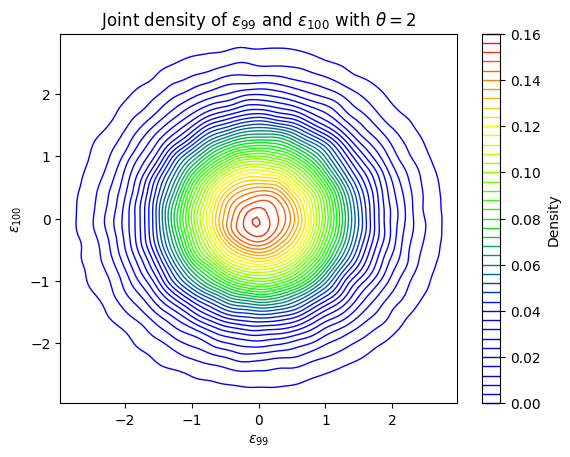

In [34]:
#change theta above to see change the plots here as well
range_ = [-3, 3]
H, xedges, yedges = np.histogram2d(eps[:, 98], eps[:, 99], bins=100, density=True, weights=weights, range=[range_, range_])
# Apply Gaussian filter to smooth the histogram data
H_smooth = gaussian_filter(H, sigma=2)  # Adjust sigma for more or less smoothing

xcenters = (xedges[:-1] + xedges[1:]) / 2
ycenters = (yedges[:-1] + yedges[1:]) / 2
X, Y = np.meshgrid(xcenters, ycenters)

plt.contour(X, Y, H_smooth.T, levels=40, linewidths=1, cmap=custom_cmap)
plt.colorbar(label='Density')

plt.xlabel('$\epsilon_{99}$')
plt.ylabel('$\epsilon_{100}$')
plt.title(f'Joint density of $\\epsilon_{{99}}$ and $\\epsilon_{{100}}$ with $\\theta = {theta}$')

Text(0.5, 1.0, 'Joint density of $Z$ and $\\epsilon_{100}$ with $\\theta = 2$')

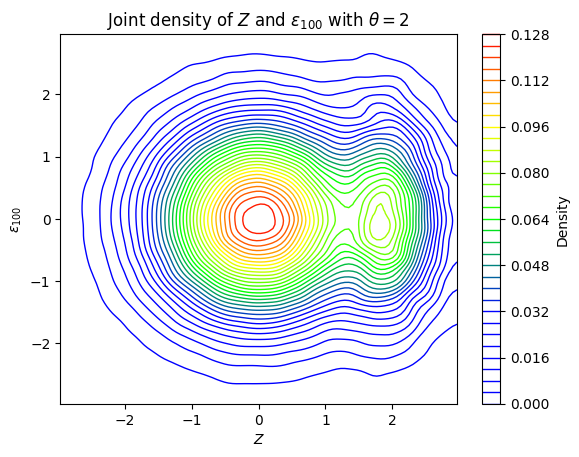

In [36]:
range_ = [-3, 3]
H, _, _ = np.histogram2d(Z, eps[:, 99], bins=100, density=True, weights=weights, range=[range_, range_])
# Apply Gaussian filter to smooth the histogram data
H_smooth = gaussian_filter(H, sigma=2)  # Adjust sigma for more or less smoothing

plt.contour(X, Y, H_smooth.T, levels=40, linewidths=1, cmap=custom_cmap)
plt.colorbar(label='Density')

plt.xlabel('$Z$')
plt.ylabel('$\epsilon_{100}$')
plt.title(f'Joint density of $Z$ and $\\epsilon_{{100}}$ with $\\theta = {theta}$')

Text(0.5, 1.0, 'Joint density of $X_{99}$ and $X_{100}$ with $\\theta = 2$')

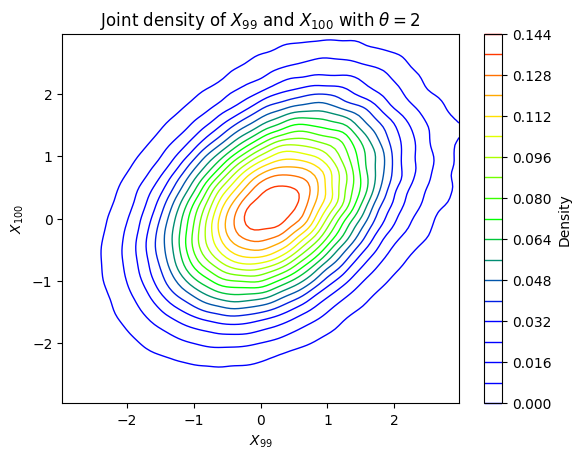

In [37]:
range_ = [-3, 3]
H, _, _ = np.histogram2d(X_i[:, 98], X_i[:, 99], bins=100, density=True, weights=weights, range=[range_, range_])
# Apply Gaussian filter to smooth the histogram data
H_smooth = gaussian_filter(H, sigma=2)  # Adjust sigma for more or less smoothing

plt.contour(X, Y, H_smooth.T, levels=20, linewidths=1, cmap=custom_cmap)
plt.colorbar(label='Density')

plt.xlabel('$X_{{99}}$')
plt.ylabel('$X_{{100}}$')
plt.title(f'Joint density of $X_{{99}}$ and $X_{{100}}$ with $\\theta = {theta}$')

Text(0.5, 1.0, 'Ratio of worst-case density to nominal density')

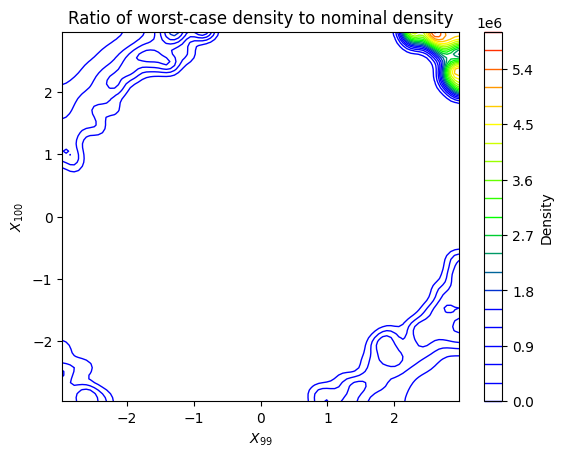

In [38]:
H_nominal, _, _ = np.histogram2d(X_i[:, 98], X_i[:, 99], bins=100, density=True, range=[range_, range_])
ratio = H_smooth / (H_nominal + 1e-10) # Avoid division by zero

H_smooth = gaussian_filter(ratio, sigma=2)  # Adjust sigma for more or less smoothing

plt.contour(X, Y, H_smooth.T, levels=20, linewidths=1, cmap=custom_cmap)
plt.colorbar(label='Density')

plt.xlabel('$X_{{99}}$')
plt.ylabel('$X_{{100}}$')
plt.title(f'Ratio of worst-case density to nominal density')

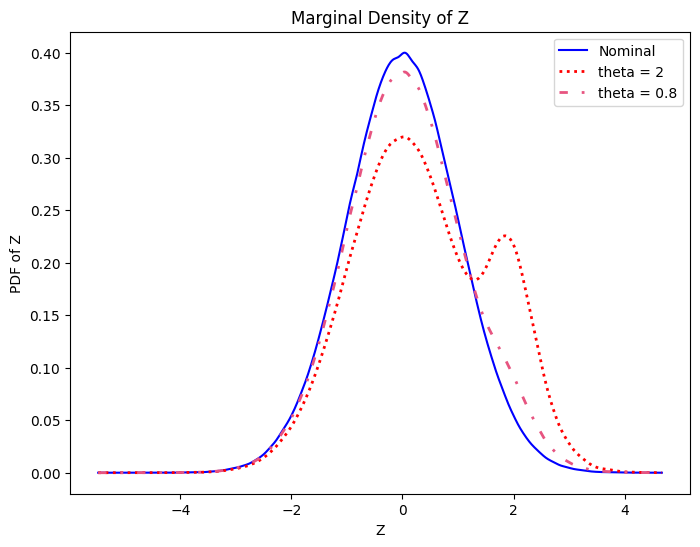

In [39]:
#Marginal density of Z and L under worst scenario with θ = 0.8 and θ = 2 vs. nominal model.
x = np.linspace(min(Z), max(Z), 1000)
plt.figure(figsize=(8, 6))

kde = gaussian_kde(Z)
density = kde.evaluate(x)
plt.plot(x, density, color='blue', linestyle='solid', linewidth=1.5, label='Nominal')

theta1 = 2
weights1 = np.exp(theta1 * L_greater_tail_th)
kde = gaussian_kde(Z, weights=weights1)
density = kde.evaluate(x)
plt.plot(x, density, color='red', linestyle='dotted', linewidth=2, label='theta = 2')


theta2 = 0.8
weights2 = np.exp(theta2 * L_greater_tail_th)
kde = gaussian_kde(Z, weights=weights2)
density = kde.evaluate(x)
plt.plot(x, density, color='#E75480', linestyle = (0, (3, 5, 1, 5)), linewidth=2, label='theta = 0.8')

plt.xlabel('Z')
plt.ylabel('PDF of Z')
plt.title('Marginal Density of Z')
plt.legend(loc='best')
plt.show()

In [40]:
def Loss(xi):
    defaults = xi > th
    loss = np.sum(defaults * ci)
    return loss

losses = np.apply_along_axis(Loss, 1, X_i)

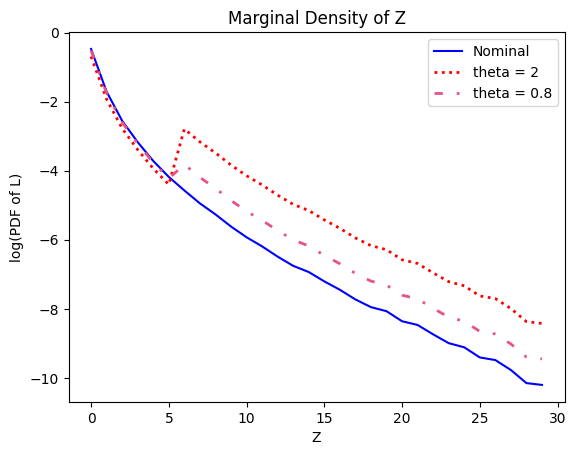

In [41]:
plot_upto = 30
dens,x = np.histogram(losses, bins= max(losses), density=True)
plt.plot(x[:plot_upto], np.log(dens[:plot_upto]), color='blue', linestyle='solid', linewidth=1.5, label='Nominal')

dens,x = np.histogram(losses, bins= max(losses), density=True, weights = weights1)
plt.plot(x[:plot_upto], np.log(dens[:plot_upto]), color='red', linestyle='dotted', linewidth=2, label='theta = 2')

dens,x = np.histogram(losses, bins= max(losses), density=True, weights = weights2)
plt.plot(x[:plot_upto], np.log(dens[:plot_upto]), color='#E75480', linestyle = (0, (3, 5, 1, 5)), linewidth=2, label='theta = 0.8')

plt.xlabel('Z')
plt.ylabel('log(PDF of L)')
plt.title('Marginal Density of Z')
plt.legend(loc='best')
plt.show()